In [568]:
import json
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import os
import cv2

In [553]:
def label(file):
    return [1,0] if file['meta']['clinical']['benign_malignant']=='benign' else [0,1]

In [554]:
def relabel(arr):
    if arr[1]==0 and arr[0]==1:
        return 'benign'
    elif arr[0]==0 and arr[1]==1:
        return 'malignant'

In [664]:
data=[]

#load data
for path in [['benign/*.jpeg', 'b_desc/'],['malignant/*.jpeg', 'm_desc/']]:
    for filepath in glob.iglob(path[0]):
        sample=filepath.split('/')[-1].split('.jpeg')[0]
        img=cv2.resize(cv2.imread(filepath,cv2.IMREAD_GRAYSCALE), (50,50))
        with open(path[1]+sample) as json_file:
            file=json.load(json_file)
        data.append([np.array(img,dtype='float64'),np.array(label(file), dtype='uint8')])

shuffle(data)
data=np.array(data, dtype=object)
train_data=np.array(data[:7000],dtype=object)
test_data=np.array(data[7000:],dtype=object)

#k batch testing
# dataset=np.array_split(data,10)

In [665]:
np.save('train_data.npy', train_data)
np.save('test_data.npy',test_data)

# np.save('batch_dataset.npy',dataset)

<AxesSubplot:ylabel='count'>

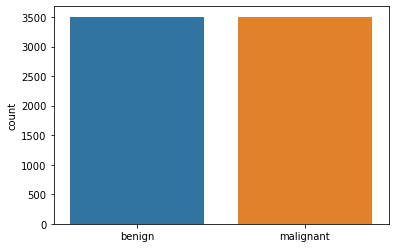

In [666]:
#split stats
train=[relabel(i[1]) for i in train_data]
test=[relabel(i[1]) for i in test_data]

sns.countplot(x=train)

<AxesSubplot:ylabel='count'>

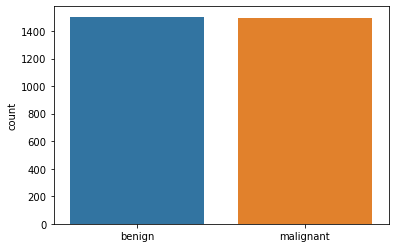

In [667]:
sns.countplot(x=test)

In [668]:
data=[]

#load data
for filepath in glob.iglob('complete_mednode_dataset/melanoma/*.jpg'):
    img=cv2.resize(cv2.imread(filepath,cv2.IMREAD_GRAYSCALE), (50,50))
    data.append([np.array(img, dtype='float64'),np.array([0,1], dtype='uint8')])
    
for filepath in glob.iglob('complete_mednode_dataset/naevus/*.jpg'):
    img=cv2.resize(cv2.imread(filepath,cv2.IMREAD_GRAYSCALE), (50,50))
    data.append([np.array(img, dtype='float64'),np.array([1,0], dtype='uint8')])

data=np.array(data, dtype=object)
np.save('mednode_data.npy',data)

In [687]:
tf.compat.v1.reset_default_graph()

# Real-time image preprocessing
img_prep = tflearn.ImagePreprocessing()
# Zero Center (With mean computed over the whole dataset)
img_prep.add_featurewise_zero_center()
# STD Normalization (With std computed over the whole dataset)
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
img_aug.add_random_flip_leftright()
imgaug.add_random_90degrees_rotation()
imgaug.add_random_blur()

# Add these methods into an 'input_data' layer
convnet = input_data(shape=[None, 50, 50, 1],
#                      data_preprocessing=img_prep,
                     data_augmentation=img_aug,
                     name ='input')

# convnet = input_data(shape =[None, 50, 50, 1], name ='input')
convnet = conv_2d(convnet, 16, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 12, activation ='relu')
convnet = max_pool_2d(convnet, 12)

convnet = conv_2d(convnet, 16, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 512, activation ='relu')
convnet = dropout(convnet, 0.8)
 
convnet = fully_connected(convnet, 2, activation ='softmax')
convnet = regression(convnet, optimizer ='adam', learning_rate = 1e-3,
      loss ='categorical_crossentropy', name ='targets')
 
model = tflearn.DNN(convnet, tensorboard_dir ='log')

# Test-train split

In [688]:
train_data = np.load('train_data.npy', allow_pickle=True)
test_data = np.load('test_data.npy', allow_pickle=True)

In [689]:
X = np.array([i[0] for i in train_data]).reshape(-1, 50, 50, 1)
Y = [i[1] for i in train_data]
test_x = np.array([i[0] for i in test_data]).reshape(-1, 50, 50, 1)
test_y = [i[1] for i in test_data]

# epoch = 5 taken
model.fit({'input': X}, {'targets': Y}, n_epoch = 10,
    validation_set =({'input': test_x}, {'targets': test_y}),
    snapshot_step = 500, show_metric = True)

Training Step: 1099  | total loss: 0.25877 | time: 7.438s
| Adam | epoch: 010 | loss: 0.25877 - acc: 0.8941 -- iter: 6976/7000
Training Step: 1100  | total loss: 0.27519 | time: 8.510s
| Adam | epoch: 010 | loss: 0.27519 - acc: 0.8906 | val_loss: 0.37210 - val_acc: 0.8835 -- iter: 7000/7000
--


<AxesSubplot:>

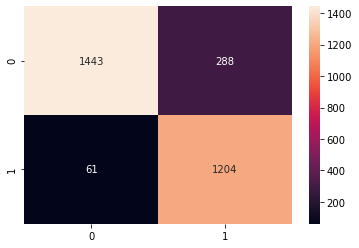

In [690]:
predictions=[relabel(np.rint(list(model.predict([i[0].reshape(50, 50, 1)])))[0]) for i in test_data]
labels=[relabel(i[1]) for i in test_data]
tp=0
tn=0
fp=0
fn=0
for i,j in zip(labels,predictions):
    if i==j=='benign':
        tp+=1
    elif i==j=='malignant':
        tn+=1
    elif i=='benign':
        fn+=1
    elif i=='malignant':
        fp+=1
df=pd.DataFrame([[tp,fp],[fn,tn]])
sns.heatmap(df, annot=True, fmt='')

# Testing on MED-NODE

In [691]:
# np.save('mednode_data.npy', data)
data=np.load('mednode_data.npy',allow_pickle=True)

<AxesSubplot:>

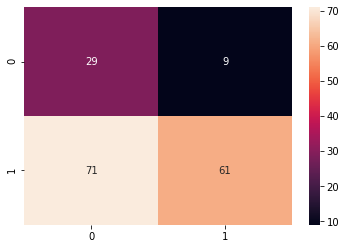

In [692]:
predictions=[relabel(np.rint(list(model.predict([i[0].reshape(50, 50, 1)])))[0]) for i in data]
labels=[relabel(i[1]) for i in data]
tp=0
tn=0
fp=0
fn=0
for i,j in zip(labels,predictions):
    if i==j=='benign':
        tp+=1
    elif i==j=='malignant':
        tn+=1
    elif i=='benign':
        fn+=1
    elif i=='malignant':
        fp+=1

df=pd.DataFrame([[tp,fp],[fn,tn]])
sns.heatmap(df, annot=True, fmt='')

# Batch training

In [191]:
train_data = np.load('train_data.npy', allow_pickle=True)
train_data=np.array_split(train_data,10)

test_data = np.load('test_data.npy', allow_pickle=True)

In [195]:
for exclude in range(10):
    X = np.array([i[0] for j in range(10) if j!=exclude for i in train_data[j]]).reshape(-1, 50, 50, 1)
    Y = [i[1] for j in range(10) if j!=exclude for i in train_data[j]]
    test_x = np.array([i[0] for i in train_data[exclude]]).reshape(-1, 50, 50, 1)
    test_y = [i[1] for i in train_data[exclude]]

    # epoch = 5 taken
    model.fit({'input': X}, {'targets': Y}, n_epoch = 10,
        validation_set =({'input': test_x}, {'targets': test_y}),
        snapshot_step = 500, show_metric = True)


Training Step: 9899  | total loss: 0.04952 | time: 7.107s
| Adam | epoch: 100 | loss: 0.04952 - acc: 0.9929 -- iter: 6272/6300
Training Step: 9900  | total loss: 0.04538 | time: 8.177s
| Adam | epoch: 100 | loss: 0.04538 - acc: 0.9936 | val_loss: 0.01960 - val_acc: 0.9957 -- iter: 6300/6300
--


<AxesSubplot:>

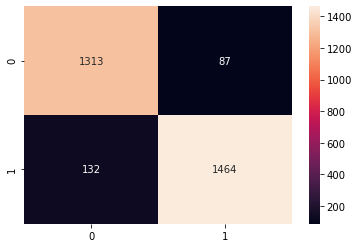

In [260]:
predictions=[relabel(np.rint(list(model.predict([i[0].reshape(50, 50, 1)])))[0]) for i in test_data]
labels=[relabel(i[1]) for i in test_data]
tp=0
tn=0
fp=0
fn=0
for i,j in zip(labels,predictions):
    if i==j=='benign':
        tp+=1
    elif i==j=='malignant':
        tn+=1
    elif i=='benign':
        fn+=1
    elif i=='malignant':
        fp+=1

df=pd.DataFrame([[tp,fp],[fn,tn]])
sns.heatmap(df, annot=True, fmt='')

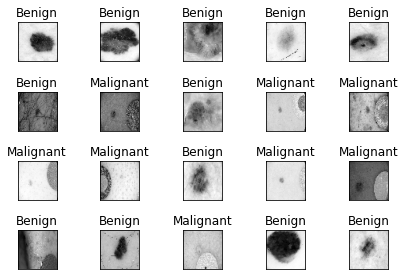

In [200]:
#check some predictions
fig=plt.figure()
for num, data in enumerate(test_data[:20]):
    # benign: [1, 0]
    # malignant: [0, 1]
    
    img_label = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 5, num + 1)
    orig = img_data
    data = img_data.reshape(50, 50, 1)
 
    model_out = model.predict([data])[0]
     
    if np.argmax(model_out) == 1: str_label ='Benign'
    else: str_label='Malignant'
    
    y.imshow(orig, cmap ='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.tight_layout()

# Testing on more ISIC data

In [264]:
data=[]
for filepath in glob.iglob('ISIC-Archive-Downloader-master/Data/Images/*.jpeg'):
    sample=filepath.split('/')[-1].split('.jpeg')[0]
    img=cv2.resize(cv2.imread(filepath,cv2.IMREAD_GRAYSCALE), (50,50))
    with open('ISIC-Archive-Downloader-master/Data/Descriptions/'+sample) as json_file:
        file=json.load(json_file)
    data.append([np.array(img),np.array(label(file))])

data=np.array(data, dtype=object)

FileNotFoundError: [Errno 2] No such file or directory: 'ISIC-Archive-Downloader-master/Data/Images/ISIC_0005784'

<AxesSubplot:>

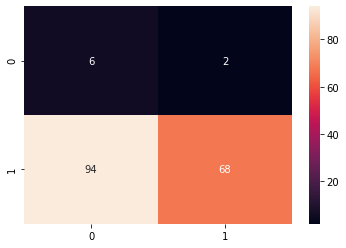

In [263]:
predictions=[relabel(np.rint(list(model.predict([i[0].reshape(50, 50, 1)])))[0]) for i in data]
labels=[relabel(i[1]) for i in data]
tp=0
tn=0
fp=0
fn=0
for i,j in zip(labels,predictions):
    if i==j=='benign':
        tp+=1
    elif i==j=='malignant':
        tn+=1
    elif i=='benign':
        fn+=1
    elif i=='malignant':
        fp+=1

df=pd.DataFrame([[tp,fp],[fn,tn]])
sns.heatmap(df, annot=True, fmt='')